Train+Val shape: (13469, 11)
Test shape: (3369, 11)

Training set shape (10775, 17)
Validation set shape (2694, 17)

 train finshed
train MSE = 8054.96
validation MSE = 18604.15
test MSE = 21469.73


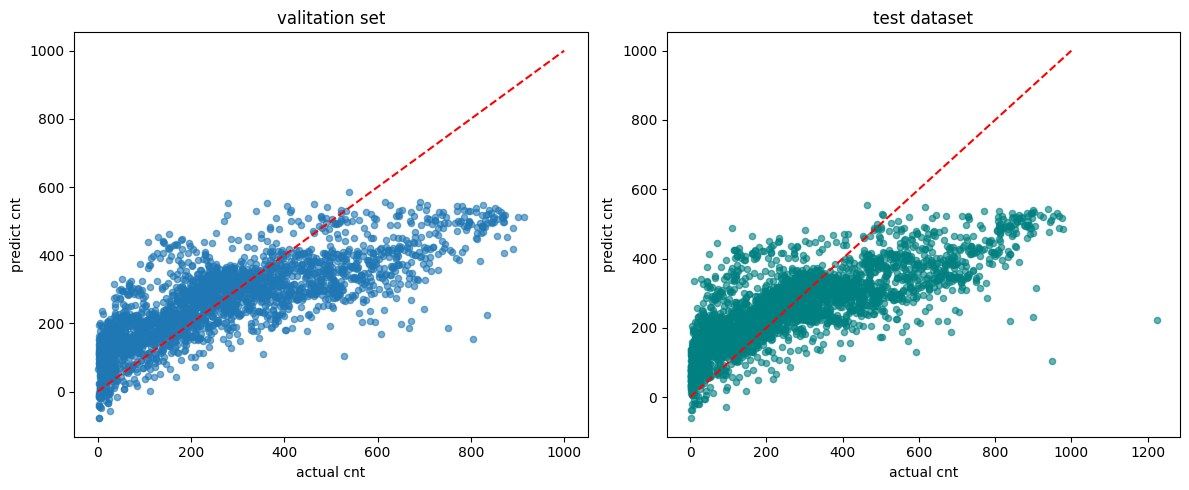


Q1 summary:
The validation MSE is  18604.1
The test MSE is 21469.7


In [5]:
#1. MGMT 687 HW1 Q1 - Linear Regression - Lichen Mao

#Step1 import common linear regression libary and name train/test dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

target = 'cnt'

# train set (regression)
df_train_val = pd.read_csv('Hour_train_validate.csv')
df_train_val.dropna(subset=[target], inplace=True)

# test set (validation)
df_test = pd.read_csv('Hour_test.csv')
df_test.dropna(subset=[target], inplace=True)

# then print the size of each dataset for reference
print(f"Train+Val shape: {df_train_val.shape}")
print(f"Test shape: {df_test.shape}")


#Step2 break the train dataset into train and validataion
# sort the data by timeline, as a train logic of use past data to predict future
df = df_train_val.copy() # Assign df_train_val to df
df['dteday'] = pd.to_datetime(df['dteday'])
df = df.sort_values(['dteday', 'hr']).reset_index(drop=True)

# Feature Engineering for df (training/validation set)
df['yr'] = df['dteday'].dt.year
df['mnth'] = df['dteday'].dt.month
df['weekday'] = df['dteday'].dt.weekday
# Simple season mapping: 1:winter, 2:spring, 3:summer, 4:fall
df['season'] = df['mnth'].apply(lambda x: (x % 12 + 3) // 3)
# Working day: 1 for Monday-Friday, 0 for Saturday-Sunday
df['workingday'] = df['weekday'].apply(lambda x: 1 if x < 5 else 0)
# Placeholder for holiday: setting all to 0. Actual holidays would require external data.
df['holiday'] = 0

#break the train dataset into 80% for train and 20% for validataion.
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_val   = df.iloc[train_size:]
#print the size of each dataset for reference
print("\nTraining set shape", df_train.shape)
print("Validation set shape", df_val.shape)


#Step3 name the result and predictors.
#'dteday' is transfered into year, month, weekday and working day to show the influence of weekday or season.
#'casual','registered' is dropped as their sum is cnt
#'temp' was dropped as it there are another temperature parameter 'atemp'
features = ['season', 'yr', 'mnth', 'hr', 'holiday',
            'weekday', 'workingday', 'weathersit','atemp', 'hum', 'windspeed']
# target = 'cnt' moved to top of the cell

# Apply the same feature engineering to df_test
df_test['dteday'] = pd.to_datetime(df_test['dteday'])
df_test['yr'] = df_test['dteday'].dt.year
df_test['mnth'] = df_test['dteday'].dt.month
df_test['weekday'] = df_test['dteday'].dt.weekday
df_test['season'] = df_test['mnth'].apply(lambda x: (x % 12 + 3) // 3)
df_test['workingday'] = df_test['weekday'].apply(lambda x: 1 if x < 5 else 0)
df_test['holiday'] = 0

# name x and y
X_train = df_train[features]
y_train = df_train[target]

X_val   = df_val[features]
y_val   = df_val[target]

X_test  = df_test[features]
y_test  = df_test[target]

#Step4. regression the linear model
#standardlize the data into numerical data
numeric_features = [ 'atemp', 'hum', 'windspeed']
#standarlize the categorical data into categorical
categorical_features = ['season', 'yr', 'mnth', 'hr', 'holiday',
                        'weekday', 'workingday', 'weathersit']

# Create pipelines for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

#use ColumnTransformer to process numerical data and cateegorical data separately
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# name processing pipeline then regress and train the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)
print("\n train finshed")

#Step5 visiualization
# name print_mse to calculate the MSE
def print_mse(name, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    print(f"{name} MSE = {mse:.2f}")
    return mse
#show the mse for each dataset
train_mse = print_mse("train", X_train, y_train)
val_mse   = print_mse("validation", X_val,   y_val)
test_mse  = print_mse("test", X_test,  y_test)
# draw the figure to show the difference of actual and predict in validataion dataset and test dataset
plt.figure(figsize=(12, 5))
# fig.1 validation set
plt.subplot(1, 2, 1)
plt.scatter(y_val, model.predict(X_val), alpha=0.6, s=20)
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel('actual cnt')
plt.ylabel('predict cnt')
plt.title('valitation set')
# fig.2 test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, model.predict(X_test), alpha=0.6, s=20, color='teal')
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel('actual cnt')
plt.ylabel('predict cnt')
plt.title('test dataset')
plt.tight_layout()
plt.show()
#Summary of MSE
print("\nQ1 summary:")
print(f"The validation MSE is  {val_mse:.1f}")
print(f"The test MSE is {test_mse:.1f}")

In [6]:
# Step 6: Display Regression Model Coefficients

# Get feature names after preprocessing
numeric_feature_names = numeric_features

categorical_encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = list(categorical_encoder.get_feature_names_out(categorical_features))

# Combine all feature names
all_feature_names = numeric_feature_names + categorical_feature_names

# Get coefficients from the linear regression model
coefficients = model.named_steps['regressor'].coef_

# Create a DataFrame to display coefficients
coefficients_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

print("\nRegression Model Coefficients:")
display(coefficients_df.sort_values(by='Coefficient', ascending=False))


Regression Model Coefficients:


,Feature,Coefficient
34,hr_17.0,280.992850
35,hr_18.0,250.720358
25,hr_8.0,220.974504
36,hr_19.0,157.867220
33,hr_16.0,146.247843
29,hr_12.0,110.578112
30,hr_13.0,103.200743
26,hr_9.0,102.001052
24,hr_7.0,100.653995
32,hr_15.0,99.122388
